# 1 Introduction

Check the Python version.

In [ ]:
import os
if not os.exists("venv"):
    !python3.11 -m venv venv
    !source venv/bin/activate
    !pip install -r requirements.txt

In [ ]:
!python --version

Python 3.11.0


Import the required libraries.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import load_model, Model
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import os
from pathlib import Path
from io import BytesIO
matplotlib.rcParams["figure.figsize"] = (12, 12)
matplotlib.rcParams["axes.grid"] = False
# ensures it can only access the first GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

ImportError: Traceback (most recent call last):
  File "C:\Users\Layo\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

Check tensorflow version.

In [ ]:
print("TensorFlow version:", tf.__version__)

In [ ]:
print(tf.keras.__version__)

## 1.1 Checking the environment of the project

Checking if the project is in Google Colab.

Check the Python version.

In [ ]:
!python --version

Python 3.11.0


In [ ]:
import importlib
def check_if_on_colab():
    on_colab = 'google.colab' in str(get_ipython())
    return on_colab 

In [ ]:
on_colab = check_if_on_colab()

Checking if the project is in Kaggle.

In [ ]:
import sys
KAGGLE_DIR_PATH = "/kaggle/input/"
KAGGLE_SCRIPT_PATHS =  ["/kaggle/input/helper-functions", "/kaggle/input/shared-utils", "/kaggle/input/video_utils"]
on_kaggle : bool = True if any("kaggle" in path for path in sys.path) else False

Adding additional base paths to access scripts in the project.

In [ ]:

def add_base_script_paths(on_kaggle = False, on_colab = False):
  if on_colab:
    sys.path.append('/content/drive/MyDrive')
    nb_path = '/content/drive/MyDrive/Library'
    os.makedirs(nb_path, exist_ok=True)
    sys.path.insert(0,nb_path)
    
  elif on_kaggle:
    kaggle_dir_path = KAGGLE_DIR_PATH
    kaggle_script_paths = KAGGLE_SCRIPT_PATHS
    sys.path.insert(1, kaggle_dir_path)
    for x in  kaggle_script_paths:
      if x not in sys.path:
        sys.path.insert(1, x)
  else:
    sys.path.append('..')
        

In [ ]:
add_base_script_paths(on_kaggle,on_colab)

In [ ]:
def clone_repo(should_clone = False):
    if should_clone:
        !git config --global url."https://<YOUR_TOKEN>@github.com/".insteadOf "https://github.com/"
        !git clone --filter=blob:none --no-checkout https://github.com/Averagenormaljoe/Neural-Style-Transfer.git
        !cd Neural-Style-Transfer
        !git sparse-checkout init --cone
        !git sparse-checkout set shared_utils
        !git sparse-checkout set video_utils
        !git sparse-checkout set forward_feed/CIN
        !git sparse-checkout set forward_feed/model_functions
        !git sparse-checkout set forward_feed/model_components
        !git sparse-checkout set forward_feed/image_helper
        !git checkout

In [ ]:
def is_drive_mounted():
    drive_path = "/content/drive"
    return os.path.exists(drive_path)

In [ ]:
drive_available = is_drive_mounted()

In [ ]:
from shared_utils.colab_functions import download_libraries
if on_colab:
    nb_path = '/content/drive/MyDrive/Library'
    download_libraries(nb_path)

# Utility Functions

In [ ]:
from image_helper.load_url_image import load_url_image

In [ ]:
from image_helper.plot_images import show_image, plot_images_grid

# Pretrained Model Instantiate

In [ ]:
def get_vgg():
    vgg = vgg19.VGG19(weights="imagenet", include_top=False)
    vgg.trainable = False
    return vgg

80142336/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
vgg = get_vgg()

In [ ]:
vgg.summary()

# Defining Content and Style layers from pretrained model

In [ ]:
content_layers = ["block4_conv2"]
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layers_weights = [1]
style_layers_weights = [1] * 5

# Creating Loss model it is used to calcuate perceptual loss

In [ ]:
from model_functions.LossModel import LossModel

In [ ]:
def get_loss_model(content_layers, style_layers):
    vgg = get_vgg()
    loss_model = LossModel(vgg, content_layers, style_layers,)
    return loss_model

In [ ]:
loss_model = get_loss_model(content_layers, style_layers)

# Defining Losses

In [ ]:
from model_functions.losses import content_loss,style_loss

In [ ]:
def preceptual_loss(
    predicted_activations,
    content_activations,
    style_activations,
    content_weight,
    style_weight,
    content_layers_weights,
    style_layer_weights,
):
    all_metrics = {}
    pred_content = predicted_activations["content"]
    pred_style = predicted_activations["style"]
    c_loss = tf.add_n(
        [
            content_loss(
                pred_content[name], content_activations[name], content_layers_weights[i]
            )
            for i, name in enumerate(pred_content.keys())
        ]
    )
    all_metrics["content_loss"] = c_loss
    c_loss = c_loss * content_weight
    s_loss = tf.add_n(
        [
            style_loss(
                pred_style[name], style_activations[name], style_layer_weights[i]
            )
            for i, name in enumerate(pred_style.keys())
        ]
    )
    all_metrics["style_loss"] = s_loss
    s_loss = s_loss * style_weight
    t_loss = c_loss + s_loss
    return all_metrics, t_loss

# Fast Neural Style Transfer Model Architecture
- Residual Layers
- Encoder Decoder Model

In [ ]:
from model_components.ReflectionPadding2D import ReflectionPadding2D

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)

    def call(self, inputs):
        batch, rows, cols, channels = [i for i in inputs.get_shape()]
        mu, var = tf.nn.moments(inputs, [1, 2], keepdims=True)
        shift = tf.Variable(tf.zeros([channels]))
        scale = tf.Variable(tf.ones([channels]))
        epsilon = 1e-3
        normalized = (inputs - mu) / tf.sqrt(var + epsilon)
        return scale * normalized + shift

In [ ]:
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, **kwargs):
        super(ConvLayer, self).__init__(**kwargs)
        self.padding = ReflectionPadding2D([k // 2 for k in kernel_size])
        self.conv2d = tf.keras.layers.Conv2D(filters, kernel_size, strides)
        self.bn = InstanceNormalization()

    def call(self, inputs):
        x = self.padding(inputs)
        x = self.conv2d(x)
        x = self.bn(x)
        return x

In [ ]:
from model_components.StyleTransferModel import StyleTransferModel

In [ ]:
input_shape = (256, 256, 3)
batch_size = 4

In [ ]:
style_model = StyleTransferModel()

In [ ]:
style_model.print_shape(tf.zeros(shape=(1, *input_shape)))

(1, 256, 256, 3)
(1, 256, 256, 32)
(1, 128, 128, 64)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 128, 128, 64)
(1, 256, 256, 32)
(1, 256, 256, 3)


# Training Utility Functions

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
def apply_loss_and_grad(tape,loss,optimizer =optimizer, style_model=style_model):
    grad = tape.gradient(loss, style_model.trainable_variables)
    optimizer.apply_gradients(zip(grad, style_model.trainable_variables))
    return grad

In [ ]:
from shared_utils.get_custom_metrics import get_custom_metrics

In [ ]:
from shared_utils.LoopLogger import LoopLogger

In [ ]:
def clip_image(image):
    image = tf.clip_by_value(image, 0, 255)
    return image

In [ ]:
def get_loss_activations(img, input_image_batch, loss_model=loss_model):
 
    pred_activations = loss_model.get_activations(img / 255.0)
    content_activations = loss_model.get_activations(input_image_batch)[
                "content"
            ]
    return pred_activations, content_activations

In [ ]:
@tf.function
def apply_style_transfer(input_image_batch,loss_model,style_activations, content_weight,style_weight,content_layers_weights,style_layers_weights ,total_variation_weight ) -> tuple[tf.Tensor, tf.Tensor, dict]:
    with tf.GradientTape() as tape:
        outputs = style_model(input_image_batch)
        clip_outputs = clip_image(outputs)
        pred_activations, content_activations = get_loss_activations(clip_outputs, input_image_batch,loss_model)
        all_metrics,curr_loss = preceptual_loss(
            pred_activations,
            content_activations,
            style_activations,
            content_weight,
            style_weight,
            content_layers_weights,
            style_layers_weights,
        )
        tv_loss = total_variation_weight * tf.image.total_variation(clip_outputs)
        curr_loss += tv_loss
    all_metrics["total_variation_loss"] = tv_loss
    apply_loss_and_grad(tape, curr_loss, optimizer, style_model)
    return clip_outputs,curr_loss, all_metrics

In [ ]:
def train_step(
    dataset,
    style_activations,
    steps_per_epoch,
    style_model,
    loss_model,
    optimizer,
    content_weight=1e4,
    style_weight=1e-2,
    total_variation_weight=0.004,
    content_layers_weights=[1],
    style_layers_weights=[1] * 5,
    config = {}
):
    batch_losses : list = []
    steps : int = 1
    save_step = config.get("save_step", 1000)
    checkpoint_path = config.get("checkpoint_path", "./")
    loop_logger = LoopLogger(config)
    base_name = "model_checkpoint"
    save_path : str = os.path.join(checkpoint_path, f"{base_name}.ckpt")
    weights_path = os.path.join(checkpoint_path, f"{base_name}.weights.h5")

    print("Model Checkpoint Path: ", save_path)
    for input_image_batch in dataset:
        if steps - 1 >= steps_per_epoch:
            break
        clip_outputs, curr_loss, all_metrics = apply_style_transfer(
            input_image_batch, loss_model, style_activations, content_weight, style_weight,
            content_layers_weights, style_layers_weights, total_variation_weight
        )
        batch_losses.append(curr_loss)
        if steps % save_step == 0:
            print("checkpoint saved ", end=" ")
            for x in all_metrics:
                all_metrics[x] = all_metrics[x].numpy()
            checkpoint = tf.train.Checkpoint(model=style_model)
            checkpoint.save(save_path)
            style_model.save_weights(weights_path)
            custom_metrics = loop_logger.get_custom_metrics(input_image_batch[0], clip_outputs[0])
            all_metrics.update(custom_metrics)
            loop_logger.add(all_metrics)

            mean_batch_loss = tf.reduce_mean(batch_losses).numpy()
            print(f"Loss: {mean_batch_loss}")
        steps += 1
    log_data = loop_logger.end_training()
    return log_data,tf.reduce_mean(batch_losses)

# Configure Dataset for training

In [ ]:
def download_dataset():
    if os.path.exists("train2014.zip"):
        print("MSCOCO dataset already downloaded.")
        return
    !wget http://images.cocodataset.org/zips/train2014.zip

In [ ]:
def download_wikiart_dataset():
    if os.path.exists("wikiart.zip"):
        print("WikiArt dataset already downloaded.")
        return

In [ ]:
def download_davis_dataset():
    if os.path.exists("DAVIS-data.zip"):
        print("DAVIS dataset already downloaded.")
        return
    !wget https://graphics.ethz.ch/Downloads/Data/Davis/DAVIS-data.zip
    !unzip DAVIS-data.zip -d DAVIS
    !rm DAVIS-data.zip

In [ ]:
def download_flying_chairs_dataset():
    if os.path.exists("FlyingChairs.zip"):
        print("Flying Chairs dataset already downloaded.")
        return
    !wget https://lmb.informatik.uni-freiburg.de/data/FlyingChairs/FlyingChairs.zip
    !unzip FlyingChairs.zip -d FlyingChairs
    !rm FlyingChairs.zip

In [ ]:
download_dataset()

In [ ]:
def unzip_dataset():
    if os.path.exists("coco/train2014.zip"):
        print("MSCOCO dataset already unzipped.")
        return
    !mkdir coco
    !unzip -qq train2014.zip -d coco
    if os.path.exists("coco/train2014"):
        !rm train2014.zip

In [ ]:
unzip_dataset()

In [ ]:
from shared_utils.image_utils import tf_decode_jpeg
class TensorflowDatasetLoader:
    def __init__(
        self, dataset_path, batch_size=4, image_size=(256, 256), num_images=None
    ):
        extension = "*.jpg"
        images_paths = [str(path) for path in Path(dataset_path).glob(extension)]
        self.length = len(images_paths)
        if num_images is not None:
            images_paths = images_paths[0:num_images]
        dataset = tf.data.Dataset.from_tensor_slices(images_paths).map(
            lambda path: self.load_tf_image(path, dim=image_size),
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.repeat()
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        self.dataset = dataset

    def __len__(self):
        return self.length

    def load_tf_image(self, image_path, dim):
        image = tf_decode_jpeg(image_path)
        image = tf.image.resize(image, dim)
        image = image / 255.0
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image

In [ ]:
loader = TensorflowDatasetLoader("coco/train2014/", batch_size=4)

In [ ]:
loader.dataset.element_spec

TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None)

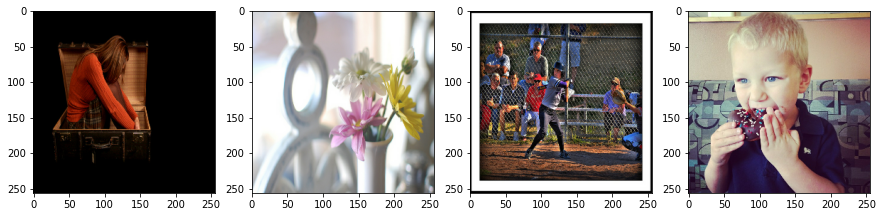

In [ ]:
plot_images_grid(next(iter(loader.dataset.take(1))))

In [ ]:
# setting up style image
def get_url_image(url : str):
    style_image = load_url_image(url, dim=(input_shape[0], input_shape[1]), resize=True)
    normalize_style_image = style_image / 255.0
    return normalize_style_image

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/300px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

In [ ]:
from image_helper.load_image import load_image

def get_image(url):
    if url.startswith("http"):
        image = get_url_image(url)
    else:
        base_image = load_image(url, dim=(input_shape[0], input_shape[1]), resize=True)
        image = base_image / 255.0
    return image

In [ ]:
style_image = get_url_image(url)

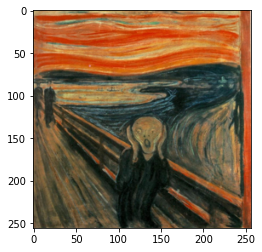

In [ ]:
show_image(style_image)

In [ ]:
def get_style_activations(style_image, loss_model):
    style_image = style_image.astype(np.float32)
    style_image_batch = np.repeat([style_image], batch_size, axis=0)
    style_activations = loss_model.get_activations(style_image_batch)["style"]
    return style_activations

In [ ]:
style_activations = get_style_activations(style_image, loss_model)

## 2 Training the Model

### 2.1

In [ ]:
epochs = 2
content_weight = 1e1
style_weight = 1e2
total_variation_weight = 0.004

In [ ]:
def get_steps_per_epoch(loader, batch_size):
    num_images = len(loader)
    steps_per_epochs = num_images // batch_size
    return steps_per_epochs

20695


In [ ]:
steps_per_epochs = get_steps_per_epoch(loader, batch_size)

In [ ]:
def get_save_path(top_folder_name = "scream", model_save_path = "../content/drive/MyDrive/Models", enable_versions = False,resume = 1):
    os.makedirs(model_save_path, exist_ok=True)
    save_path = os.path.join(model_save_path, top_folder_name)
    version = 1
    final_top_folder_name = top_folder_name
    if enable_versions:
        while os.path.exists(save_path):
            final_top_folder_name = f"{top_folder_name}_v{version}"
            save_path = os.path.join(model_save_path, f"{final_top_folder_name}")
            version += 1
    print("Save Path: ", save_path)
    os.makedirs(save_path, exist_ok=True)
    return save_path, final_top_folder_name

In [ ]:
top_folder_name = "scream"
base_model_path = "Models/scream"
model_path = f"../content/drive/MyDrive/{base_model_path}" if drive_available else base_model_path
save_path,final_top_folder_name = get_save_path(top_folder_name,base_model_path)

In [ ]:
from shared_utils.policy import control_policy

In [ ]:
control_policy(enable_mixed_precision=True)

In [ ]:
from model_functions.setup_jit import setup_jit

In [ ]:
setup_jit()

In [ ]:
def load_training_checkpoint_weights(style_model,save_path : str):
    if os.path.isfile(os.path.join(save_path, "model_checkpoint.ckpt.index")):
        ckpt_path = os.path.join(save_path, "model_checkpoint.ckpt")
        checkpoint = tf.train.Checkpoint(model=style_model)
        checkpoint.restore(ckpt_path).expect_partial()
        print("resuming training ...")
    else:
        print("training scratch ...")

training scratch ...


In [ ]:
def load_h5_weights(style_model, save_path : str):
    weights_path = os.path.join(save_path, "model_checkpoint.weights.h5")
    if os.path.isfile(weights_path):
        style_model.load_weights(weights_path)
        print("resuming training ...")
    else:
        print("training scratch ...")

In [ ]:
def build_model(input_shape, save_path):
    style_model = StyleTransferModel()
    dummy_input = tf.zeros(shape=(1, *input_shape),dtype=tf.dtypes.float32)
    _ = style_model(dummy_input)
    load_h5_weights(style_model, save_path)
    return style_model

In [ ]:
style_model = build_model(input_shape, save_path)

NameError: name 'input_shape' is not defined

In [ ]:
def training_loop(save_path, style_activations= style_activations, style_model=style_model, optimizer=optimizer):
    epoch_losses = []
    logs = []
    config = {}
    config["checkpoint_path"] = save_path
    for epoch in range(1, epochs + 1):
        print(f"epoch: {epoch}")
        log_data,batch_loss = train_step(
            loader.dataset,
            style_activations,
            steps_per_epochs,
            style_model,
            loss_model,
            optimizer,
            content_weight,
            style_weight,
            total_variation_weight,
            content_layers_weights,
            style_layers_weights,
            config=config
        )
        base_name = "model_checkpoint"
        checkpoint_path = os.path.join(save_path, f"{base_name}.ckpt")
        weights_path = os.path.join(save_path, f"{base_name}.weights.h5")
        os.makedirs(save_path, exist_ok=True)
        checkpoint = tf.train.Checkpoint(model=style_model)
        checkpoint.save(checkpoint_path)
        style_model.save_weights(weights_path)
      
        print("Model Checkpointed at: ", checkpoint_path)
        loss = batch_loss.numpy()
        print(f"loss: {loss}")
        epoch_losses.append(batch_loss)
        logs.append(log_data)
    return logs,epoch_losses

epoch: 1
Model Checkpoint Path:  ../gdrive/My Drive/scream/model_checkpoint.ckpt
checkpoint saved  Loss: 6567731.5
checkpoint saved  Loss: 6464426.5
checkpoint saved  Loss: 6402768.0
checkpoint saved  Loss: 6336974.5
checkpoint saved  Loss: 6281922.5
checkpoint saved  Loss: 6232056.0
checkpoint saved  Loss: 6191586.5
checkpoint saved  Loss: 6155332.0
checkpoint saved  Loss: 6119712.5
checkpoint saved  Loss: 6085571.5
checkpoint saved  Loss: 6062698.0
checkpoint saved  Loss: 6036787.0
checkpoint saved  Loss: 6011265.5
checkpoint saved  Loss: 5988809.5
checkpoint saved  Loss: 5969908.0
checkpoint saved  Loss: 5950925.0
checkpoint saved  Loss: 5931179.5
checkpoint saved  Loss: 5912791.5
checkpoint saved  Loss: 5894602.0
checkpoint saved  Loss: 5880713.0
Model Checkpointed at:  ../gdrive/My Drive/scream
loss: 5869695.5
epoch: 2
Model Checkpoint Path:  ../gdrive/My Drive/scream/model_checkpoint.ckpt
checkpoint saved  Loss: 5520494.5
checkpoint saved  Loss: 5532450.5
checkpoint saved  Loss: 

In [ ]:
logs, epoch_losses = training_loop(save_path,style_activations, style_model,optimizer)

In [ ]:
import pandas as pd
def save_logs_table(logs, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
    
    enumerate_logs = enumerate(logs)
    for i, x in enumerate_logs:
        df = pd.DataFrame(x)
        filename = f"logs_epoch_{i}.csv"
        csv_path = os.path.join(save_path, filename)
        df.to_csv(csv_path, index=False)

In [ ]:
save_logs_table(logs, save_path)

In [ ]:
from shared_utils.file_nav import get_base_name

In [ ]:
def create_model(style_images):
    model_logs = []
    model_epoch_losses = []
    lr = 1e-3
    for img in style_images:
        name = get_base_name(img)
        save_path = get_save_path(name)
        style_activations = get_style_activations(img, loss_model)
        style_model = StyleTransferModel()
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        load_h5_weights(style_model,save_path)
        logs, epoch_losses = training_loop(save_path, style_activations, style_model, optimizer)
        model_logs.append(logs)
        model_epoch_losses.append(epoch_losses)
    return style_model

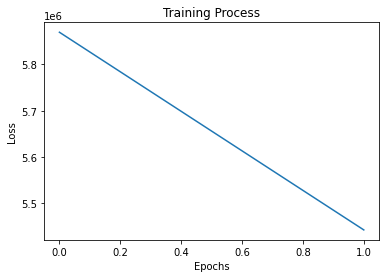

In [ ]:
def plot_epochs(epoch_losses):
    fig_size = (12, 8)
    plt.figure(figsize=fig_size)
    plt.plot(epoch_losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Process")
    plt.show()


In [ ]:
plot_epochs(epoch_losses)

In [ ]:
load_h5_weights(style_model, save_path)

loading weights ...


In [ ]:
def save_keras_model(style_model,save_path, top_folder_name):
    model_name = f"{save_path}/{top_folder_name}_model.keras"
    style_model.save(model_name)
    h5_model_name = f"{save_path}/{top_folder_name}_model.h5"
    style_model.save(h5_model_name)
    pb_model_name = f'{save_path}/serving_{top_folder_name}_model'
    style_model.export(pb_model_name)

In [ ]:
save_keras_model(style_model, final_top_folder_name)

### 2.5 Testing the model on an image

In [ ]:
test_image_url = "https://github.com/hwalsuklee/tensorflow-fast-style-transfer/raw/master/content/chicago.jpg"

In [ ]:
dim = (640, 480)
test_image = load_url_image(test_image_url, dim=dim)

In [ ]:
def apply_model(img,style_model, show_image=True):
    test_image = np.expand_dims(img, axis=0)
    converted_image = test_image / 255.0
    cast_img = converted_image.astype(np.float32)
    predicted_img = style_model(cast_img)
    clip_predicted_img = np.clip(predicted_img, 0, 255)
    int8_predicted_img = clip_predicted_img.astype(np.uint8)
    output =  int8_predicted_img.astype(np.uint8)
    test_output = tf.squeeze(output).numpy()
    predicted_output = tf.squeeze(int8_predicted_img).numpy()
    all_metrics = get_custom_metrics(test_image, predicted_output)
    if show_image:
        plot_images_grid([test_output, predicted_output])
    return test_output, predicted_output, all_metrics    

In [ ]:
test_output, predicted_output, all_metrics = apply_model(test_image, style_model, show_image=True)

## 3 Video Neural Style Transfer

### 3.1 Setup

In this section, the project will import the required libraries.

In [ ]:
from video_utils.helper.get_flow_and_wrap import get_flow_and_wrap
from video_utils.helper.reset_warp_frames import reset_warp_frames

In [ ]:
from video_utils.helper.process_flow_on_frames import process_flow_on_frames

In [ ]:
from video_utils.helper.loop_through_videos import loop_through_videos

### 3.2 Performing video NST

Now, the project will loop and execute the libraries.

In [ ]:
from video_utils.compute import compute_temporal_loss
from video_utils.get_flow_and_mask import get_flow_and_mask
def apply_video(content_frame,style_frame,config):
    config = get_flow_and_mask(config, content_frame)
    test_output, predicted_output, all_metrics = apply_model(content_frame, style_model, show_image=False)
    t_loss = compute_temporal_loss(test_output, config)
            
    if t_loss > 0:
        all_metrics["temporal_loss"] = t_loss
    config = reset_warp_frames(config)
    return [],test_output, all_metrics

Define the sample images and video.

In [ ]:
style_paths = ["../demo_images/mosaic.jpg","../demo_images/candy.jpg", "../demo_images/art16.jpg", "../demo_images/art16.jpg.png"]
video_content_path = "../demo_video/man_at_sea_sliced.mp4"
total_logs = loop_through_videos(apply_video,style_paths, video_content_path)

The end of the notebook.